In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from typing import *
from src.preprocess.dataset import Dataset
from src.preprocess.result import ResultData
import numpy as np
import lasso as mml
import pandas as pd
from sklearn.metrics import mean_squared_error

dataset_names: Optional[List[str]]

result_data = ResultData(
    datadict = True, # Optional[Dict[str, pd.DataFrame]]
    ml_ready = True, # Optional[pd.DataFrame]
    metadata = True  # Optional["Metadata"]
    )

dataset = Dataset()

result_data = dataset.get(result_data)
ml_data : pd.DataFrame = result_data.ml_ready

In [2]:
ml_data.head()

,date,country,fdi_net_inflows_current_usd,unemployment_rate_percent_of_total_labor_force,gdp_current_usd,life_expectancy_at_birth_total_years,economic_activity,population_size,total_population,petroleum_energy_production,hydro_electric_energy_production,area,education_years,services_value_added_percent_of_gdp
0,1991-01-01,afghanistan,-2.800000e+05,8.070,3.521418e+09,45.521000,48.278000,12238879.0,12238879.0,6.462682,93.537315,652860.0,6.0,36.151154
1,1991-01-01,albania,2.000000e+07,10.304,1.099559e+09,73.000999,69.087997,3266790.0,3266790.0,7.857517,92.142487,28750.0,4.0,39.772518
2,1991-01-01,algeria,1.163869e+07,20.600,4.571568e+10,67.692001,48.102001,25987928.0,25987928.0,4.318247,1.689248,2381740.0,6.0,38.978500
3,1991-01-01,angola,6.645000e+08,16.855,1.060378e+10,43.812000,77.780998,12023529.0,12023529.0,17.344753,82.655243,1246700.0,4.0,33.061611
4,1991-01-01,argentina,2.439000e+09,5.440,1.897200e+11,72.019997,66.294998,33230294.0,33230294.0,14.425220,38.194340,2780400.0,7.0,60.561199


# Ideia da lag regression:
- Vamos treinar um modelo da seguinte forma:
$$
Y_t = \beta_0 + \beta_1 X1_{t-1} + \beta_2 X1_{t-1} + ... + \beta_{n} X1_{t-n} + \beta_{n+1} X2_{t-1} + ... + \epsilon
$$

Ou seja, treinaremos o modelo para predizer daqui 1 ano qual o valor daquele indíce macroeconômico. Na regressão também será adicionada termos não lineares para as covariáveis (não os parâmetros), isto é $X1^2$ etc.

Se quisermos predizer mais de 1 ano, usamos o output dessa regressão e consideramos o tempo dela como Y_t

In [3]:
ml_data['date'] = pd.to_datetime(ml_data['date'])

In [4]:
ml_data.head()

,date,country,fdi_net_inflows_current_usd,unemployment_rate_percent_of_total_labor_force,gdp_current_usd,life_expectancy_at_birth_total_years,economic_activity,population_size,total_population,petroleum_energy_production,hydro_electric_energy_production,area,education_years,services_value_added_percent_of_gdp
0,1991-01-01,afghanistan,-2.800000e+05,8.070,3.521418e+09,45.521000,48.278000,12238879.0,12238879.0,6.462682,93.537315,652860.0,6.0,36.151154
1,1991-01-01,albania,2.000000e+07,10.304,1.099559e+09,73.000999,69.087997,3266790.0,3266790.0,7.857517,92.142487,28750.0,4.0,39.772518
2,1991-01-01,algeria,1.163869e+07,20.600,4.571568e+10,67.692001,48.102001,25987928.0,25987928.0,4.318247,1.689248,2381740.0,6.0,38.978500
3,1991-01-01,angola,6.645000e+08,16.855,1.060378e+10,43.812000,77.780998,12023529.0,12023529.0,17.344753,82.655243,1246700.0,4.0,33.061611
4,1991-01-01,argentina,2.439000e+09,5.440,1.897200e+11,72.019997,66.294998,33230294.0,33230294.0,14.425220,38.194340,2780400.0,7.0,60.561199


In [5]:
ml_data['year'] = pd.to_datetime(ml_data['date']).dt.year

# Agrupar por ano e calcular a média global de cada coluna numérica
data_yearly = ml_data.groupby('year').mean(numeric_only=True).reset_index()
data_yearly.to_csv("data_yearly.csv")

In [6]:
#Se quiser chamar um país específico
#nome_do_pais_2 = "United States" 
#dados_do_pais_2 = dataset.get_country_data(nome_do_pais_2)

In [7]:
data_yearly.shape

(34, 13)

In [8]:
data_yearly.tail()

,year,fdi_net_inflows_current_usd,unemployment_rate_percent_of_total_labor_force,gdp_current_usd,life_expectancy_at_birth_total_years,economic_activity,population_size,total_population,petroleum_energy_production,hydro_electric_energy_production,area,education_years,services_value_added_percent_of_gdp
29,2020,7.599101e+09,8.357717,5.411143e+11,71.929886,65.392792,66184912.0,66184912.0,20.285028,27.716516,1049080.375,5.703911,56.316345
30,2021,1.488503e+10,8.065601,6.185527e+11,71.152771,65.963745,66849128.0,66849128.0,20.095518,27.948982,1049047.625,5.703911,54.470936
31,2022,1.159605e+10,7.222426,6.484203e+11,72.569153,66.649094,67551424.0,67551424.0,20.277540,27.519590,1048861.125,5.703911,53.757912
32,2023,5.552446e+09,6.971260,6.775097e+11,73.314804,66.781082,68276072.0,68276072.0,20.204382,27.649940,1048861.125,5.698324,54.891308
33,2024,5.615381e+09,6.939905,6.775097e+11,73.314804,66.800301,68276072.0,68276072.0,20.204382,27.649940,1048861.125,5.698324,54.891308


In [9]:
FILE_PATH = 'data_yearly.csv'
TARGET_VARIABLE = 'gdp_current_usd' # <--- ESCOLHA A COLUNA QUE VOCÊ QUER PREVER!
TRAIN_LIMIT_YEAR = 2018
LASSO_PARAMS = {'cv': 5, 'max_iter': 100000, 'n_jobs': -1, 'tol': 0.001, 'n_alphas': 10000}
# my_alphas = np.linspace(0.05, 1.0, 1000) # 100 alfas entre 0.05 e 1.0

print(f"Arquivo de Dados: {FILE_PATH}")
print(f"Variável Alvo:    {TARGET_VARIABLE}")
print(f"Ano Limite Treino:{TRAIN_LIMIT_YEAR}")

Arquivo de Dados: data_yearly.csv
Variável Alvo:    gdp_current_usd
Ano Limite Treino:2018


Dados carregados de 'data_yearly.csv'.
Removendo colunas 'Unnamed': ['Unnamed: 0']
Usando 'year' como índice.

Treinando o Modelo LassoCV...
Treinamento concluído. Melhor Alpha (α) encontrado: 0.011848

Avaliando o Modelo...
--- Resultados da Avaliação ---
   --- Escala Padronizada (Média 0, Desvio Padrão 1) ---
      - EQM (MSE):  0.0451
      - REQM (RMSE): 0.2123

   --- Escala Original ---
      - EQM (MSE):  814,608,798,539,376,099,328.00
      - REQM (RMSE): 28,541,352,430.10
      - MAPE:       3.73%

--- Atributos Selecionados pelo Modelo (Coeficientes) ---
gdp_current_usd_lag1                                   0.6063
fdi_net_inflows_current_usd_lag1                       0.0521
services_value_added_percent_of_gdp_lag1               0.0015
unemployment_rate_percent_of_total_labor_force_lag1   -0.0057
economic_activity_lag1                                -0.0278
petroleum_energy_production_lag1                      -0.3476


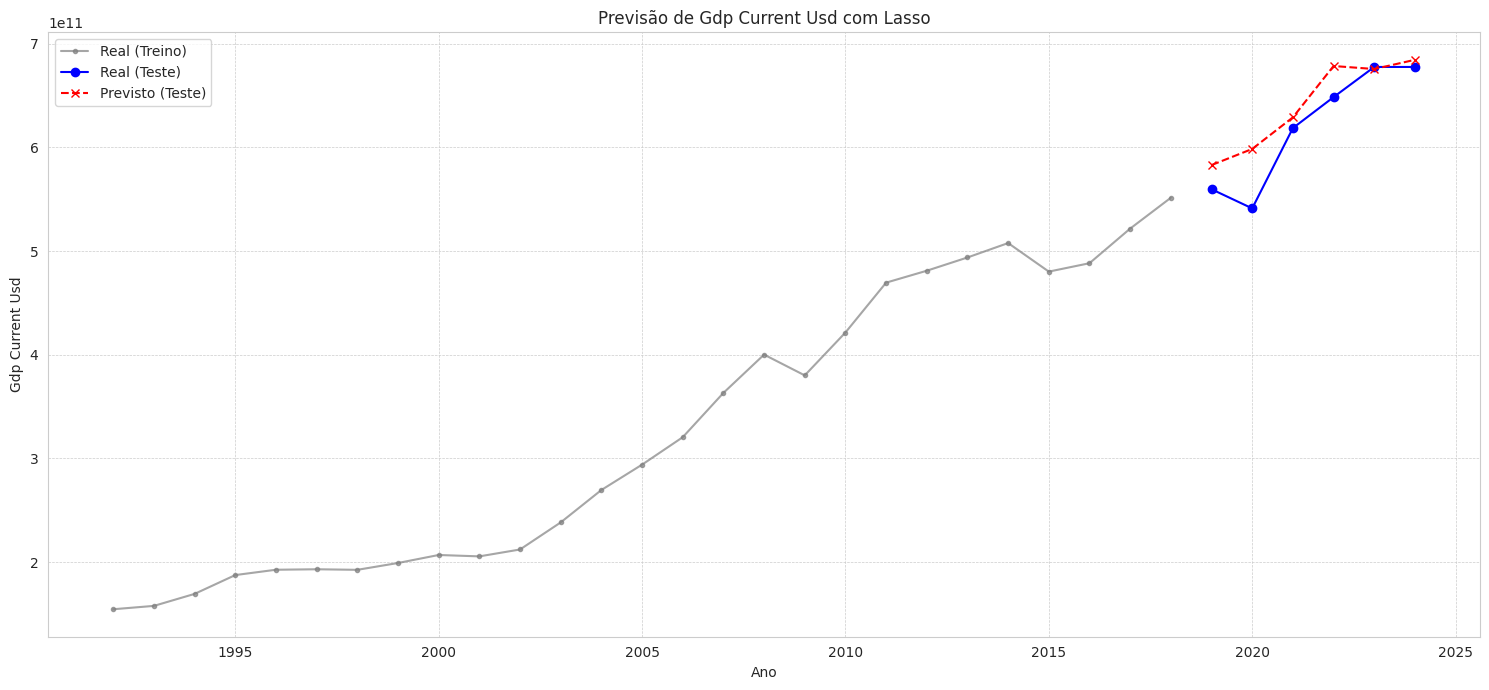

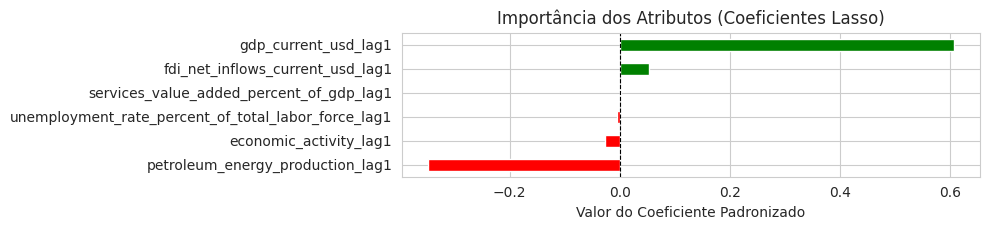

In [10]:
data = mml.load_and_prepare_data(FILE_PATH)
X, y = mml.engineer_features(data, TARGET_VARIABLE)

# 3. Divisão e Normalização (só continua se X, y foram criados)

split_result = mml.split_and_scale_data(X, y, TRAIN_LIMIT_YEAR)

# 4. Treinamento (só continua se a divisão funcionou)
(X_train_s, X_test_s, y_train_s, y_test_s,
 y_train, y_test, x_scaler, y_scaler) = mml.split_and_scale_data(X, y, TRAIN_LIMIT_YEAR)
model = mml.train_lasso_model(X_train_s, y_train_s, **LASSO_PARAMS)
# model = mml.train_lasso_model_guided_cv(X_train_s, y_train_s, alpha_list=my_alphas, **LASSO_PARAMS)

# 5. Avaliação
y_pred, metrics = mml.evaluate_model(model, X_test_s, y_test, y_test_s, y_scaler)# 6. Visualização e Coeficientes
mml.display_coefficients(model, X.columns)
mml.plot_predictions(y_train, y_test, y_pred, TARGET_VARIABLE)
mml.plot_coefficients(model, X.columns)

In [11]:
mml.explain_coefficients(model, X.columns, TARGET_VARIABLE, x_scaler, y_scaler)

AVISO: O modelo mostra associação, não causalidade. A interpretação descreve padrões nos dados.

Para converter o impacto para a escala original, utilize a seguinte referência:
  -> 1 desvio padrão (DP) de 'gdp_current_usd' equivale a 134,454,680,399.75 unidades.
------------------------------------------------------------
Associações encontradas pelo modelo (na escala padronizada):

🔹 Atributo: gdp_current_usd_lag1
   - Uma variação de 1 desvio padrão neste atributo está associada a uma mudança média de
     +0.6063 desvios padrão (DPs) na variável 'gdp_current_usd'.

🔹 Atributo: petroleum_energy_production_lag1
   - Uma variação de 1 desvio padrão neste atributo está associada a uma mudança média de
     -0.3476 desvios padrão (DPs) na variável 'gdp_current_usd'.

🔹 Atributo: fdi_net_inflows_current_usd_lag1
   - Uma variação de 1 desvio padrão neste atributo está associada a uma mudança média de
     +0.0521 desvios padrão (DPs) na variável 'gdp_current_usd'.

🔹 Atributo: economic_a

## Criando dataset por país


In [12]:
data_albania = dataset.get_country_data('albania')

data_albania.head()

,year,fdi_net_inflows_current_usd,unemployment_rate_percent_of_total_labor_force,gdp_current_usd,life_expectancy_at_birth_total_years,economic_activity,population_size,total_population,petroleum_energy_production,hydro_electric_energy_production,area,education_years,services_value_added_percent_of_gdp
0,1991,20000000.0,10.304000,1.099559e+09,73.000999,69.087997,3266790.0,3266790.0,7.857517,92.142487,28750.0,4.0,39.772518
1,1992,20000000.0,30.007000,6.521750e+08,73.303001,69.788002,3247039.0,3247039.0,4.949912,95.050087,28750.0,4.0,39.772518
2,1993,58000000.0,25.250999,1.185315e+09,73.638000,69.112999,3227287.0,3227287.0,6.092378,93.907623,28750.0,4.0,39.772518
3,1994,53000000.0,20.834999,1.880951e+09,73.836998,68.572998,3207536.0,3207536.0,4.313626,95.686371,28750.0,4.0,39.772518
4,1995,70000000.0,14.607000,2.392765e+09,74.022003,67.723000,3187784.0,3187784.0,6.013861,93.986137,28750.0,4.0,39.772518


In [13]:
data_albania.isna().sum()

year                                              0
fdi_net_inflows_current_usd                       0
unemployment_rate_percent_of_total_labor_force    0
gdp_current_usd                                   0
life_expectancy_at_birth_total_years              0
economic_activity                                 0
population_size                                   0
total_population                                  0
petroleum_energy_production                       0
hydro_electric_energy_production                  0
area                                              0
education_years                                   0
services_value_added_percent_of_gdp               0
dtype: int64

In [14]:
data_albania.to_csv("data_albania.csv")

In [15]:
data_brazil = dataset.get_country_data('brazil')

data_brazil.to_csv("data_brazil.csv")

## Testando um país no modelo treinado com a média global



Iniciando Previsão para Novos Dados: 'data_albania.csv'

Dados carregados de 'data_albania.csv'.
Removendo colunas 'Unnamed': ['Unnamed: 0']
Usando 'year' como índice.

Alinhamento de colunas concluído. X_new_aligned: (33, 12)
Novos dados normalizados.
Previsões (escaladas) realizadas.

--- Previsões Finais (Escala Original) ---
year
1992    4.281691e+11
1993    4.289047e+11
1994    4.319792e+11
1995    4.862037e+11
1996    4.854921e+11
1997    5.313833e+11
1998    5.122701e+11
1999    5.206478e+11
2000    5.547679e+11
2001    5.429969e+11
2002    5.367397e+11
2003    5.145222e+11
2004    6.107314e+11
2005    6.274625e+11
2006    6.721082e+11
2007    6.865823e+11
2008    6.927889e+11
2009    7.690684e+11
2010    7.138605e+11
2011    7.034410e+11
2012    5.739882e+11
2013    6.815029e+11
2014    7.815102e+11
2015    7.419623e+11
2016    6.810750e+11
2017    6.386300e+11
2018    6.265401e+11
2019    5.998170e+11
2020    5.716548e+11
2021    6.263291e+11
2022    5.973017e+11
2023    5.49

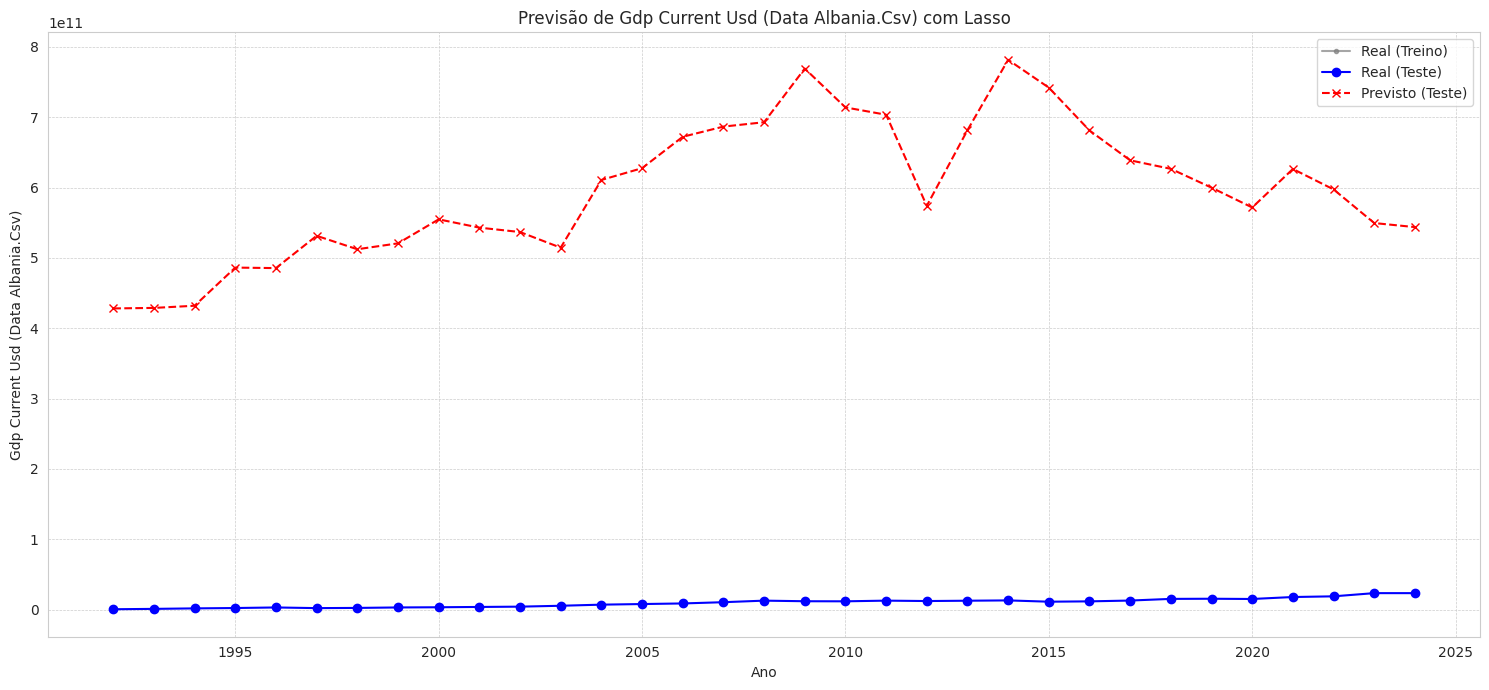


Processo de Previsão em Novos Dados Concluído.



In [16]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

# --- PREVISÃO EM NOVOS DADOS (data_albania.csv) ---
# Certifique-se que 'mml', 'model', 'x_scaler', 'y_scaler', 'X', 
# e 'TARGET_VARIABLE' estão definidos e se referem ao treino GLOBAL.

# 1. Definir o caminho para os novos dados
FILE_PATH_NEW = 'data_albania.csv' # Ou 'data_brazil.csv', etc.
print(f"\n{'='*60}")
print(f"Iniciando Previsão para Novos Dados: '{FILE_PATH_NEW}'")
print(f"{'='*60}\n")

# 2. Carregar e Preparar os Novos Dados
data_new = mml.load_and_prepare_data(FILE_PATH_NEW)

# Prosseguir apenas se os dados foram carregados
if data_new is not None:

    # 3. Aplicar Engenharia de Atributos
    X_new, y_new = mml.engineer_features(data_new, TARGET_VARIABLE)

    # Prosseguir apenas se a engenharia de atributos funcionou
    if X_new is not None:

        # 4. Alinhar Colunas
        original_feature_names = X.columns # Pega os nomes das colunas originais (GLOBAIS)
        X_new_aligned = X_new.reindex(columns=original_feature_names, fill_value=0)
        X_new_aligned = X_new_aligned.fillna(0) 

        print(f"\nAlinhamento de colunas concluído. X_new_aligned: {X_new_aligned.shape}")

        # 5. Normalizar os Novos Atributos (Usando o x_scaler *GLOBAL*)
        X_new_scaled_array = x_scaler.transform(X_new_aligned)
        X_new_scaled = pd.DataFrame(X_new_scaled_array, 
                                    columns=original_feature_names, 
                                    index=X_new_aligned.index)

        print("Novos dados normalizados.")

        # 6. Realizar Previsões (Usando o model *GLOBAL*)
        y_pred_new_scaled = model.predict(X_new_scaled)
        print("Previsões (escaladas) realizadas.")

        # 7. Reverter a Normalização das Previsões (Usando o y_scaler *GLOBAL*)
        y_pred_new_original = y_scaler.inverse_transform(y_pred_new_scaled.reshape(-1, 1)).ravel()
        predictions_series = pd.Series(y_pred_new_original, 
                                       index=X_new_scaled.index, 
                                       name=f'Predicted_{TARGET_VARIABLE}')

        print("\n--- Previsões Finais (Escala Original) ---")
        print(predictions_series.to_string())

        # 8. Avaliar se y_new existe
        if y_new is not None and not y_new.empty:
            print("\n--- Comparação com Dados Reais (se disponíveis) ---")
            
            y_new_aligned = y_new.reindex(predictions_series.index)
            valid_comparison = pd.DataFrame({'Real': y_new_aligned, 'Previsto': predictions_series}).dropna()

            if not valid_comparison.empty:
                # --- Métricas Originais ---
                mse_new = mean_squared_error(valid_comparison['Real'], valid_comparison['Previsto'])
                rmse_new = np.sqrt(mse_new)
                mape_new = mml.mean_absolute_percentage_error(valid_comparison['Real'], valid_comparison['Previsto'])

                # --- CÁLCULO NORMALIZADO (NOVO!) ---
                y_new_aligned_for_norm = valid_comparison['Real']
                # Normaliza y_new reais usando o y_scaler GLOBAL
                y_new_scaled_actual = y_scaler.transform(y_new_aligned_for_norm.values.reshape(-1, 1)).ravel()
                # Pega as previsões escaladas que correspondem aos 'Real' válidos
                y_pred_new_scaled_series = pd.Series(y_pred_new_scaled, index=X_new_scaled.index)
                y_pred_new_scaled_aligned = y_pred_new_scaled_series.reindex(y_new_aligned_for_norm.index)
                # Calcula métricas normalizadas
                mse_norm = mean_squared_error(y_new_scaled_actual, y_pred_new_scaled_aligned)
                rmse_norm = np.sqrt(mse_norm)
                # --- FIM DO CÁLCULO NORMALIZADO ---

                print("--- Métricas de Avaliação (Novos Dados) ---")
                # --- EXIBIÇÃO NORMALIZADA (NOVO!) ---
                print("   --- Escala Normalizada ---")
                print(f"      - EQM (MSE):  {mse_norm:.4f}")
                print(f"      - REQM (RMSE): {rmse_norm:.4f}")
                # --- FIM EXIBIÇÃO NORMALIZADA ---
                print("   --- Escala Original ---")
                print(f"      - EQM (MSE):  {mse_new:,.2f}")
                print(f"      - REQM (RMSE): {rmse_new:,.2f}")
                print(f"      - MAPE:       {mape_new:.2f}%")

                # 9. Visualizar
                mml.plot_predictions(pd.Series(), 
                                     valid_comparison['Real'], 
                                     valid_comparison['Previsto'], 
                                     f"{TARGET_VARIABLE} ({FILE_PATH_NEW})")
            else:
                print("Não foi possível alinhar dados reais e previstos para avaliação.")
        else:
            print("\nNão há dados reais (variável alvo) para avaliação.")

    else:
        print(f"Falha na engenharia de atributos para '{FILE_PATH_NEW}'. Previsão cancelada.")
else:
    print(f"Falha ao carregar '{FILE_PATH_NEW}'. Previsão cancelada.")

print(f"\n{'='*60}")
print("Processo de Previsão em Novos Dados Concluído.")
print(f"{'='*60}\n")


Iniciando Previsão para Novos Dados: 'data_brazil.csv'

Dados carregados de 'data_brazil.csv'.
Removendo colunas 'Unnamed': ['Unnamed: 0']
Usando 'year' como índice.

Alinhamento de colunas concluído. X_new_aligned: (33, 12)
Novos dados normalizados.
Previsões (escaladas) realizadas.

--- Previsões Finais (Escala Original) ---
year
1992    7.845651e+11
1993    7.611475e+11
1994    7.822723e+11
1995    8.718538e+11
1996    1.013001e+12
1997    1.100210e+12
1998    1.107366e+12
1999    1.097747e+12
2000    8.856200e+11
2001    9.345130e+11
2002    8.501168e+11
2003    8.034059e+11
2004    8.413282e+11
2005    9.061584e+11
2006    1.026859e+12
2007    1.175162e+12
2008    1.394825e+12
2009    1.576954e+12
2010    1.533357e+12
2011    1.967236e+12
2012    2.281827e+12
2013    2.169679e+12
2014    2.128244e+12
2015    2.105204e+12
2016    1.672633e+12
2017    1.716107e+12
2018    1.863118e+12
2019    1.793265e+12
2020    1.748518e+12
2021    1.551176e+12
2022    1.607245e+12
2023    1.8310

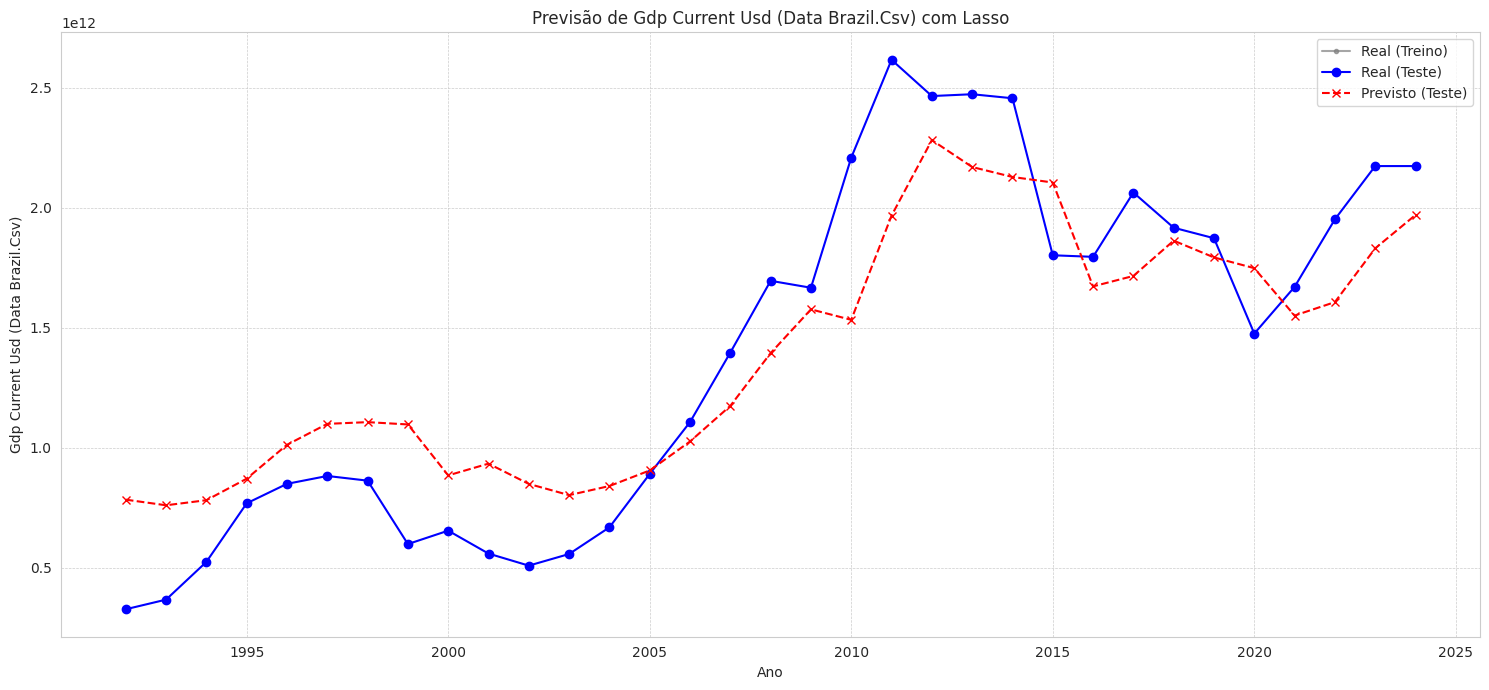

In [17]:
# 1. Definir o caminho para os novos dados
FILE_PATH_NEW = 'data_brazil.csv'
print(f"\n{'='*60}")
print(f"Iniciando Previsão para Novos Dados: '{FILE_PATH_NEW}'")
print(f"{'='*60}\n")

data_new = mml.load_and_prepare_data(FILE_PATH_NEW)

# Prosseguir apenas se os dados foram carregados
if data_new is not None:

    # 3. Aplicar Engenharia de Atributos
    X_new, y_new = mml.engineer_features(data_new, TARGET_VARIABLE)

    # Prosseguir apenas se a engenharia de atributos funcionou
    if X_new is not None:

        # 4. Alinhar Colunas
        original_feature_names = X.columns # Pega os nomes das colunas originais (GLOBAIS)
        X_new_aligned = X_new.reindex(columns=original_feature_names, fill_value=0)
        X_new_aligned = X_new_aligned.fillna(0) 

        print(f"\nAlinhamento de colunas concluído. X_new_aligned: {X_new_aligned.shape}")

        # 5. Normalizar os Novos Atributos (Usando o x_scaler *GLOBAL*)
        X_new_scaled_array = x_scaler.transform(X_new_aligned)
        X_new_scaled = pd.DataFrame(X_new_scaled_array, 
                                    columns=original_feature_names, 
                                    index=X_new_aligned.index)

        print("Novos dados normalizados.")

        # 6. Realizar Previsões (Usando o model *GLOBAL*)
        y_pred_new_scaled = model.predict(X_new_scaled)
        print("Previsões (escaladas) realizadas.")

        # 7. Reverter a Normalização das Previsões (Usando o y_scaler *GLOBAL*)
        y_pred_new_original = y_scaler.inverse_transform(y_pred_new_scaled.reshape(-1, 1)).ravel()
        predictions_series = pd.Series(y_pred_new_original, 
                                       index=X_new_scaled.index, 
                                       name=f'Predicted_{TARGET_VARIABLE}')

        print("\n--- Previsões Finais (Escala Original) ---")
        print(predictions_series.to_string())

        # 8. Avaliar se y_new existe
        if y_new is not None and not y_new.empty:
            print("\n--- Comparação com Dados Reais (se disponíveis) ---")
            
            y_new_aligned = y_new.reindex(predictions_series.index)
            valid_comparison = pd.DataFrame({'Real': y_new_aligned, 'Previsto': predictions_series}).dropna()

            if not valid_comparison.empty:
                # --- Métricas Originais ---
                mse_new = mean_squared_error(valid_comparison['Real'], valid_comparison['Previsto'])
                rmse_new = np.sqrt(mse_new)
                mape_new = mml.mean_absolute_percentage_error(valid_comparison['Real'], valid_comparison['Previsto'])

                # --- CÁLCULO NORMALIZADO (NOVO!) ---
                y_new_aligned_for_norm = valid_comparison['Real']
                # Normaliza y_new reais usando o y_scaler GLOBAL
                y_new_scaled_actual = y_scaler.transform(y_new_aligned_for_norm.values.reshape(-1, 1)).ravel()
                # Pega as previsões escaladas que correspondem aos 'Real' válidos
                y_pred_new_scaled_series = pd.Series(y_pred_new_scaled, index=X_new_scaled.index)
                y_pred_new_scaled_aligned = y_pred_new_scaled_series.reindex(y_new_aligned_for_norm.index)
                # Calcula métricas normalizadas
                mse_norm = mean_squared_error(y_new_scaled_actual, y_pred_new_scaled_aligned)
                rmse_norm = np.sqrt(mse_norm)

                print("   --- Escala Normalizada ---")
                print(f"      - EQM (MSE):  {mse_norm:.4f}")
                print(f"      - REQM (RMSE): {rmse_norm:.4f}")

                print("   --- Escala Original ---")
                print(f"      - EQM (MSE):  {mse_new:,.2f}")
                print(f"      - REQM (RMSE): {rmse_new:,.2f}")
                print(f"      - MAPE:       {mape_new:.2f}%")

                # 9. Visualizar
                mml.plot_predictions(pd.Series(), 
                                     valid_comparison['Real'], 
                                     valid_comparison['Previsto'], 
                                     f"{TARGET_VARIABLE} ({FILE_PATH_NEW})")
            else:
                print("Não foi possível alinhar dados reais e previstos para avaliação.")
        else:
            print("\nNão há dados reais (variável alvo) para avaliação.")

    else:
        print(f"Falha na engenharia de atributos para '{FILE_PATH_NEW}'. Previsão cancelada.")
else:
    print(f"Falha ao carregar '{FILE_PATH_NEW}'. Previsão cancelada.")



Iniciando Previsão para Novos Dados: 'data_argentina.csv'

Dados carregados de 'data_argentina.csv'.
Removendo colunas 'Unnamed': ['Unnamed: 0']
Usando 'year' como índice.

Alinhamento de colunas concluído. X_new_aligned: (33, 12)
Novos dados normalizados.
Previsões (escaladas) realizadas.

--- Previsões Finais (Escala Original) ---
year
1992    4.988511e+11
1993    5.318312e+11
1994    5.591212e+11
1995    6.061865e+11
1996    6.537123e+11
1997    6.498616e+11
1998    6.822109e+11
1999    6.485674e+11
2000    6.758531e+11
2001    6.893584e+11
2002    7.125224e+11
2003    6.445769e+11
2004    6.420063e+11
2005    5.917628e+11
2006    6.199731e+11
2007    6.099237e+11
2008    5.909663e+11
2009    6.427297e+11
2010    6.538352e+11
2011    6.457624e+11
2012    6.663394e+11
2013    6.959951e+11
2014    7.017250e+11
2015    7.112489e+11
2016    7.347909e+11
2017    7.236454e+11
2018    9.055700e+11
2019    8.715023e+11
2020    8.400494e+11
2021    8.520086e+11
2022    7.479810e+11
2023    

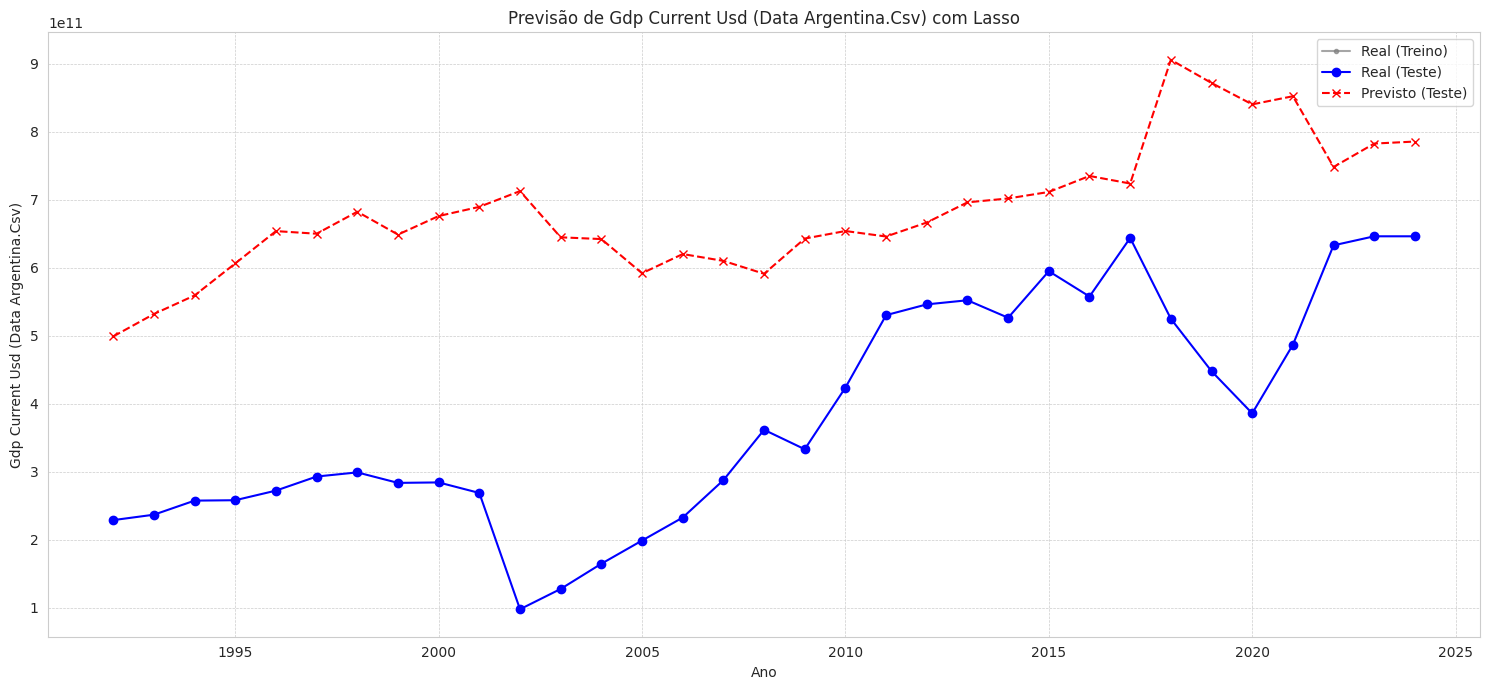

In [18]:
# 1. Definir o caminho para os novos dados
FILE_PATH_NEW = 'data_argentina.csv'
print(f"\n{'='*60}")
print(f"Iniciando Previsão para Novos Dados: '{FILE_PATH_NEW}'")
print(f"{'='*60}\n")

data_new = mml.load_and_prepare_data(FILE_PATH_NEW)

# Prosseguir apenas se os dados foram carregados
if data_new is not None:

    # 3. Aplicar Engenharia de Atributos
    X_new, y_new = mml.engineer_features(data_new, TARGET_VARIABLE)

    # Prosseguir apenas se a engenharia de atributos funcionou
    if X_new is not None:

        # 4. Alinhar Colunas
        original_feature_names = X.columns # Pega os nomes das colunas originais (GLOBAIS)
        X_new_aligned = X_new.reindex(columns=original_feature_names, fill_value=0)
        X_new_aligned = X_new_aligned.fillna(0) 

        print(f"\nAlinhamento de colunas concluído. X_new_aligned: {X_new_aligned.shape}")

        # 5. Normalizar os Novos Atributos (Usando o x_scaler *GLOBAL*)
        X_new_scaled_array = x_scaler.transform(X_new_aligned)
        X_new_scaled = pd.DataFrame(X_new_scaled_array, 
                                    columns=original_feature_names, 
                                    index=X_new_aligned.index)

        print("Novos dados normalizados.")

        # 6. Realizar Previsões (Usando o model *GLOBAL*)
        y_pred_new_scaled = model.predict(X_new_scaled)
        print("Previsões (escaladas) realizadas.")

        # 7. Reverter a Normalização das Previsões (Usando o y_scaler *GLOBAL*)
        y_pred_new_original = y_scaler.inverse_transform(y_pred_new_scaled.reshape(-1, 1)).ravel()
        predictions_series = pd.Series(y_pred_new_original, 
                                       index=X_new_scaled.index, 
                                       name=f'Predicted_{TARGET_VARIABLE}')

        print("\n--- Previsões Finais (Escala Original) ---")
        print(predictions_series.to_string())

        # 8. Avaliar se y_new existe
        if y_new is not None and not y_new.empty:
            print("\n--- Comparação com Dados Reais (se disponíveis) ---")
            
            y_new_aligned = y_new.reindex(predictions_series.index)
            valid_comparison = pd.DataFrame({'Real': y_new_aligned, 'Previsto': predictions_series}).dropna()

            if not valid_comparison.empty:
                # --- Métricas Originais ---
                mse_new = mean_squared_error(valid_comparison['Real'], valid_comparison['Previsto'])
                rmse_new = np.sqrt(mse_new)
                mape_new = mml.mean_absolute_percentage_error(valid_comparison['Real'], valid_comparison['Previsto'])

                # --- CÁLCULO NORMALIZADO (NOVO!) ---
                y_new_aligned_for_norm = valid_comparison['Real']
                # Normaliza y_new reais usando o y_scaler GLOBAL
                y_new_scaled_actual = y_scaler.transform(y_new_aligned_for_norm.values.reshape(-1, 1)).ravel()
                # Pega as previsões escaladas que correspondem aos 'Real' válidos
                y_pred_new_scaled_series = pd.Series(y_pred_new_scaled, index=X_new_scaled.index)
                y_pred_new_scaled_aligned = y_pred_new_scaled_series.reindex(y_new_aligned_for_norm.index)
                # Calcula métricas normalizadas
                mse_norm = mean_squared_error(y_new_scaled_actual, y_pred_new_scaled_aligned)
                rmse_norm = np.sqrt(mse_norm)

                print("   --- Escala Normalizada ---")
                print(f"      - EQM (MSE):  {mse_norm:.4f}")
                print(f"      - REQM (RMSE): {rmse_norm:.4f}")

                print("   --- Escala Original ---")
                print(f"      - EQM (MSE):  {mse_new:,.2f}")
                print(f"      - REQM (RMSE): {rmse_new:,.2f}")
                print(f"      - MAPE:       {mape_new:.2f}%")

                # 9. Visualizar
                mml.plot_predictions(pd.Series(), 
                                     valid_comparison['Real'], 
                                     valid_comparison['Previsto'], 
                                     f"{TARGET_VARIABLE} ({FILE_PATH_NEW})")
            else:
                print("Não foi possível alinhar dados reais e previstos para avaliação.")
        else:
            print("\nNão há dados reais (variável alvo) para avaliação.")

    else:
        print(f"Falha na engenharia de atributos para '{FILE_PATH_NEW}'. Previsão cancelada.")
else:
    print(f"Falha ao carregar '{FILE_PATH_NEW}'. Previsão cancelada.")


In [19]:
data_brazil

,year,fdi_net_inflows_current_usd,unemployment_rate_percent_of_total_labor_force,gdp_current_usd,life_expectancy_at_birth_total_years,economic_activity,population_size,total_population,petroleum_energy_production,hydro_electric_energy_production,area,education_years,services_value_added_percent_of_gdp
0,1991,1.103000e+09,6.894,3.425341e+11,66.203003,67.851997,151724256.0,151724256.0,2.174275,92.919525,8515770.0,4.0,60.549713
1,1992,2.061000e+09,7.086,3.281919e+11,66.539001,68.235001,154275072.0,154275072.0,2.581785,92.392815,8515770.0,4.0,68.357452
2,1993,1.292000e+09,6.030,3.682920e+11,66.891998,68.601997,156794576.0,156794576.0,2.429993,93.288643,8515770.0,4.0,73.337883
3,1994,3.072000e+09,6.578,5.253695e+11,67.292999,68.950996,159265008.0,159265008.0,2.454998,93.333359,8515770.0,4.0,56.894344
4,1995,4.859000e+09,7.092,7.693331e+11,67.700996,69.283997,161735072.0,161735072.0,2.721688,92.127747,8515770.0,4.0,58.121418
5,1996,1.255200e+10,8.035,8.504265e+11,68.108002,67.639999,164202544.0,164202544.0,3.178407,91.242386,8515770.0,4.0,60.318878
6,1997,1.899293e+10,9.003,8.832062e+11,68.504997,68.525002,166661664.0,166661664.0,3.213175,90.580620,8515770.0,4.0,60.605713
7,1998,2.885561e+10,10.150,8.637107e+11,68.848000,68.714996,169159648.0,169159648.0,3.458297,90.589218,8515770.0,4.0,61.118591
8,1999,2.838568e+10,11.125,5.996420e+11,69.210999,69.500000,171641536.0,171641536.0,4.935527,87.536896,8515770.0,4.0,60.203655
9,2000,3.299472e+10,10.889,6.554482e+11,69.584000,69.656998,174018288.0,174018288.0,4.347539,87.243988,8515770.0,4.0,58.251862


## Treinando e testando para cada país

In [20]:
FILE_PATH = 'data_albania.csv'
TARGET_VARIABLE = 'gdp_current_usd' # <--- ESCOLHA A COLUNA QUE VOCÊ QUER PREVER!
TRAIN_LIMIT_YEAR = 2018
LASSO_PARAMS = {'cv': 5, 'max_iter': 100000, 'n_jobs': -1, 'tol': 0.001, 'n_alphas': 10000}

print(f"Arquivo de Dados: {FILE_PATH}")
print(f"Variável Alvo:    {TARGET_VARIABLE}")
print(f"Ano Limite Treino:{TRAIN_LIMIT_YEAR}")

Arquivo de Dados: data_albania.csv
Variável Alvo:    gdp_current_usd
Ano Limite Treino:2018


Dados carregados de 'data_albania.csv'.
Removendo colunas 'Unnamed': ['Unnamed: 0']
Usando 'year' como índice.

Treinando o Modelo LassoCV...
Treinamento concluído. Melhor Alpha (α) encontrado: 0.039566

Avaliando o Modelo...
--- Resultados da Avaliação ---
   --- Escala Padronizada (Média 0, Desvio Padrão 1) ---
      - EQM (MSE):  1.2964
      - REQM (RMSE): 1.1386

   --- Escala Original ---
      - EQM (MSE):  28,587,263,301,157,310,464.00
      - REQM (RMSE): 5,346,705,836.42
      - MAPE:       21.32%

--- Atributos Selecionados pelo Modelo (Coeficientes) ---
life_expectancy_at_birth_total_years_lag1    0.6478
gdp_current_usd_lag1                         0.2991
total_population_lag1                       -0.0000
population_size_lag1                        -0.0040


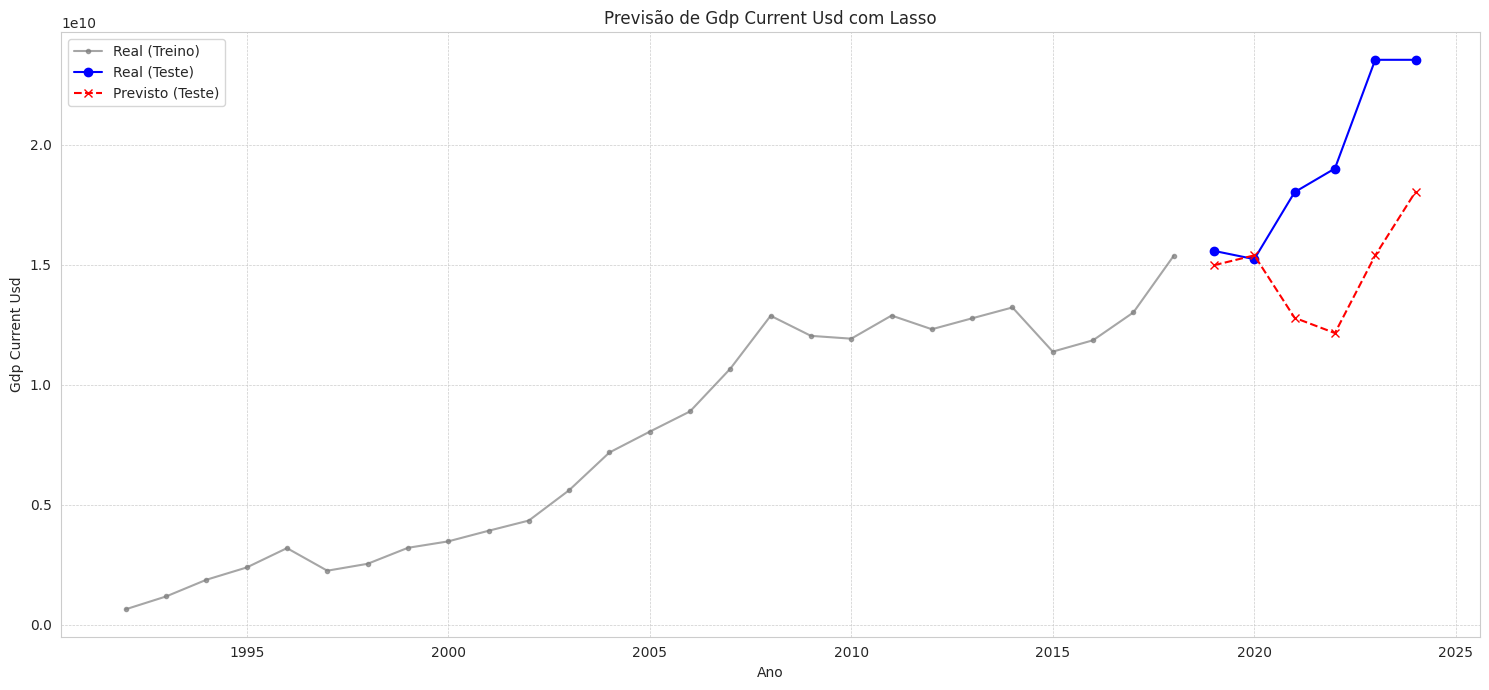

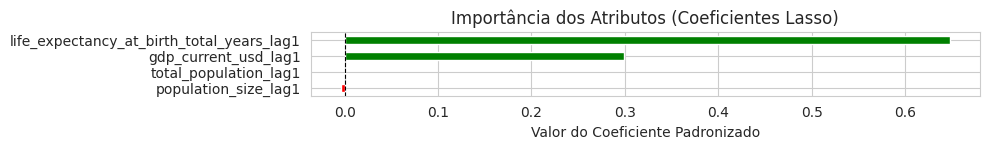

In [21]:
data = mml.load_and_prepare_data(FILE_PATH)
X, y = mml.engineer_features(data, TARGET_VARIABLE)

# 3. Divisão e Normalização (só continua se X, y foram criados)

split_result = mml.split_and_scale_data(X, y, TRAIN_LIMIT_YEAR)

# 4. Treinamento (só continua se a divisão funcionou)
(X_train_s, X_test_s, y_train_s, y_test_s,
 y_train, y_test, x_scaler, y_scaler) = mml.split_and_scale_data(X, y, TRAIN_LIMIT_YEAR)
model = mml.train_lasso_model(X_train_s, y_train_s, **LASSO_PARAMS)

# 5. Avaliação
y_pred, metrics = mml.evaluate_model(model, X_test_s, y_test, y_test_s, y_scaler)# 6. Visualização e Coeficientes
mml.display_coefficients(model, X.columns)
mml.plot_predictions(y_train, y_test, y_pred, TARGET_VARIABLE)
mml.plot_coefficients(model, X.columns)

In [22]:
mml.explain_coefficients(model, X.columns, TARGET_VARIABLE, x_scaler, y_scaler)

AVISO: O modelo mostra associação, não causalidade. A interpretação descreve padrões nos dados.

Para converter o impacto para a escala original, utilize a seguinte referência:
  -> 1 desvio padrão (DP) de 'gdp_current_usd' equivale a 4,695,894,853.64 unidades.
------------------------------------------------------------
Associações encontradas pelo modelo (na escala padronizada):

🔹 Atributo: life_expectancy_at_birth_total_years_lag1
   - Uma variação de 1 desvio padrão neste atributo está associada a uma mudança média de
     +0.6478 desvios padrão (DPs) na variável 'gdp_current_usd'.

🔹 Atributo: gdp_current_usd_lag1
   - Uma variação de 1 desvio padrão neste atributo está associada a uma mudança média de
     +0.2991 desvios padrão (DPs) na variável 'gdp_current_usd'.

🔹 Atributo: population_size_lag1
   - Uma variação de 1 desvio padrão neste atributo está associada a uma mudança média de
     -0.0040 desvios padrão (DPs) na variável 'gdp_current_usd'.

🔹 Atributo: total_populatio

In [23]:
FILE_PATH = 'data_brazil.csv'
TARGET_VARIABLE = 'gdp_current_usd' # <--- ESCOLHA A COLUNA QUE VOCÊ QUER PREVER!
TRAIN_LIMIT_YEAR = 2018
LASSO_PARAMS = {'cv': 5, 'max_iter': 100000, 'n_jobs': -1, 'tol': 0.001, 'n_alphas': 10000}

print(f"Arquivo de Dados: {FILE_PATH}")
print(f"Variável Alvo:    {TARGET_VARIABLE}")
print(f"Ano Limite Treino:{TRAIN_LIMIT_YEAR}")

Arquivo de Dados: data_brazil.csv
Variável Alvo:    gdp_current_usd
Ano Limite Treino:2018


Dados carregados de 'data_brazil.csv'.
Removendo colunas 'Unnamed': ['Unnamed: 0']
Usando 'year' como índice.

Treinando o Modelo LassoCV...
Treinamento concluído. Melhor Alpha (α) encontrado: 0.014141

Avaliando o Modelo...
--- Resultados da Avaliação ---
   --- Escala Padronizada (Média 0, Desvio Padrão 1) ---
      - EQM (MSE):  0.2277
      - REQM (RMSE): 0.4771

   --- Escala Original ---
      - EQM (MSE):  125,422,074,921,582,384,381,952.00
      - REQM (RMSE): 354,149,791,644.13
      - MAPE:       17.44%

--- Atributos Selecionados pelo Modelo (Coeficientes) ---
gdp_current_usd_lag1                                   0.8917
economic_activity_lag1                                 0.1414
life_expectancy_at_birth_total_years_lag1              0.0508
education_years_lag1                                   0.0038
unemployment_rate_percent_of_total_labor_force_lag1   -0.0323
petroleum_energy_production_lag1                      -0.1360


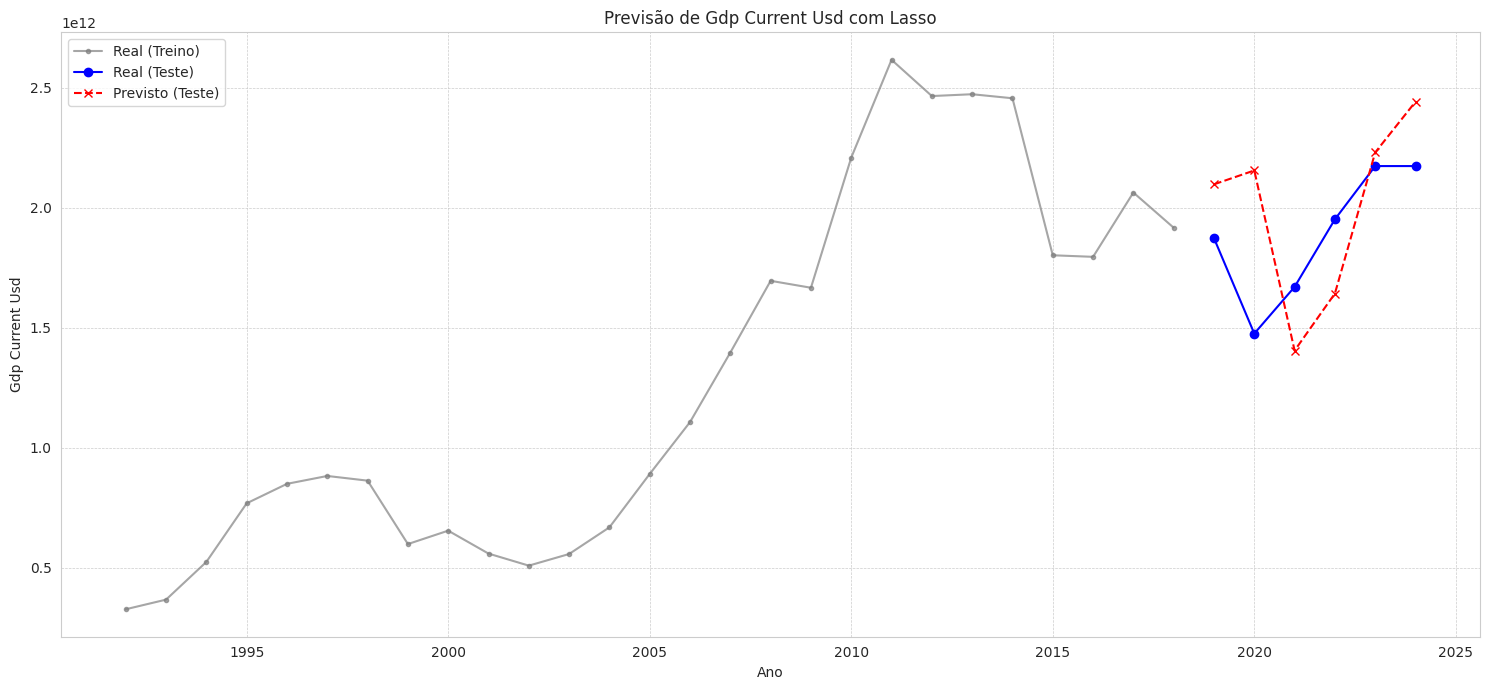

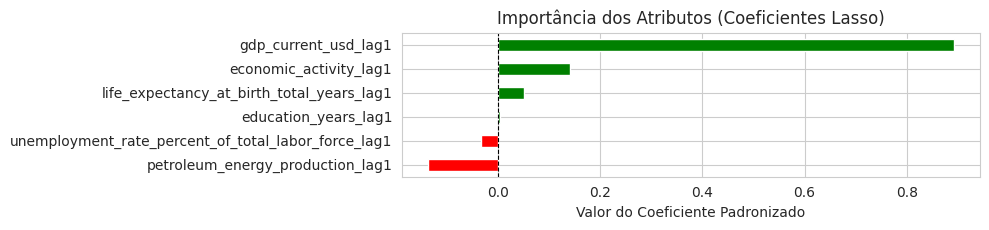

In [24]:
data = mml.load_and_prepare_data(FILE_PATH)
X, y = mml.engineer_features(data, TARGET_VARIABLE)

# 3. Divisão e Normalização (só continua se X, y foram criados)

split_result = mml.split_and_scale_data(X, y, TRAIN_LIMIT_YEAR)

# 4. Treinamento (só continua se a divisão funcionou)
(X_train_s, X_test_s, y_train_s, y_test_s,
 y_train, y_test, x_scaler, y_scaler) = mml.split_and_scale_data(X, y, TRAIN_LIMIT_YEAR)
model = mml.train_lasso_model(X_train_s, y_train_s, **LASSO_PARAMS)

# 5. Avaliação
y_pred, metrics = mml.evaluate_model(model, X_test_s, y_test, y_test_s, y_scaler)# 6. Visualização e Coeficientes
mml.display_coefficients(model, X.columns)
mml.plot_predictions(y_train, y_test, y_pred, TARGET_VARIABLE)
mml.plot_coefficients(model, X.columns)

In [25]:
mml.explain_coefficients(model, X.columns, TARGET_VARIABLE, x_scaler, y_scaler)

AVISO: O modelo mostra associação, não causalidade. A interpretação descreve padrões nos dados.

Para converter o impacto para a escala original, utilize a seguinte referência:
  -> 1 desvio padrão (DP) de 'gdp_current_usd' equivale a 742,228,300,058.89 unidades.
------------------------------------------------------------
Associações encontradas pelo modelo (na escala padronizada):

🔹 Atributo: gdp_current_usd_lag1
   - Uma variação de 1 desvio padrão neste atributo está associada a uma mudança média de
     +0.8917 desvios padrão (DPs) na variável 'gdp_current_usd'.

🔹 Atributo: economic_activity_lag1
   - Uma variação de 1 desvio padrão neste atributo está associada a uma mudança média de
     +0.1414 desvios padrão (DPs) na variável 'gdp_current_usd'.

🔹 Atributo: petroleum_energy_production_lag1
   - Uma variação de 1 desvio padrão neste atributo está associada a uma mudança média de
     -0.1360 desvios padrão (DPs) na variável 'gdp_current_usd'.

🔹 Atributo: life_expectancy_at_b

In [26]:
data_brazil = mml.engineer_features( data_brazil, 'gdp_current_usd' )

In [27]:
data_argentina = dataset.get_country_data('argentina')

data_argentina.to_csv("data_argentina.csv")

Arquivo de Dados: data_argentina.csv
Variável Alvo:    gdp_current_usd
Ano Limite Treino:2018
Dados carregados de 'data_argentina.csv'.
Removendo colunas 'Unnamed': ['Unnamed: 0']
Usando 'year' como índice.

Treinando o Modelo LassoCV...
Treinamento concluído. Melhor Alpha (α) encontrado: 0.038231

Avaliando o Modelo...
--- Resultados da Avaliação ---
   --- Escala Padronizada (Média 0, Desvio Padrão 1) ---
      - EQM (MSE):  0.2036
      - REQM (RMSE): 0.4513

   --- Escala Original ---
      - EQM (MSE):  4,737,330,692,511,788,695,552.00
      - REQM (RMSE): 68,828,269,573.71
      - MAPE:       10.92%

--- Atributos Selecionados pelo Modelo (Coeficientes) ---
gdp_current_usd_lag1                        0.6042
petroleum_energy_production_lag1            0.2087
population_size_lag1                        0.0915
services_value_added_percent_of_gdp_lag1   -0.0431
hydro_electric_energy_production_lag1      -0.0853


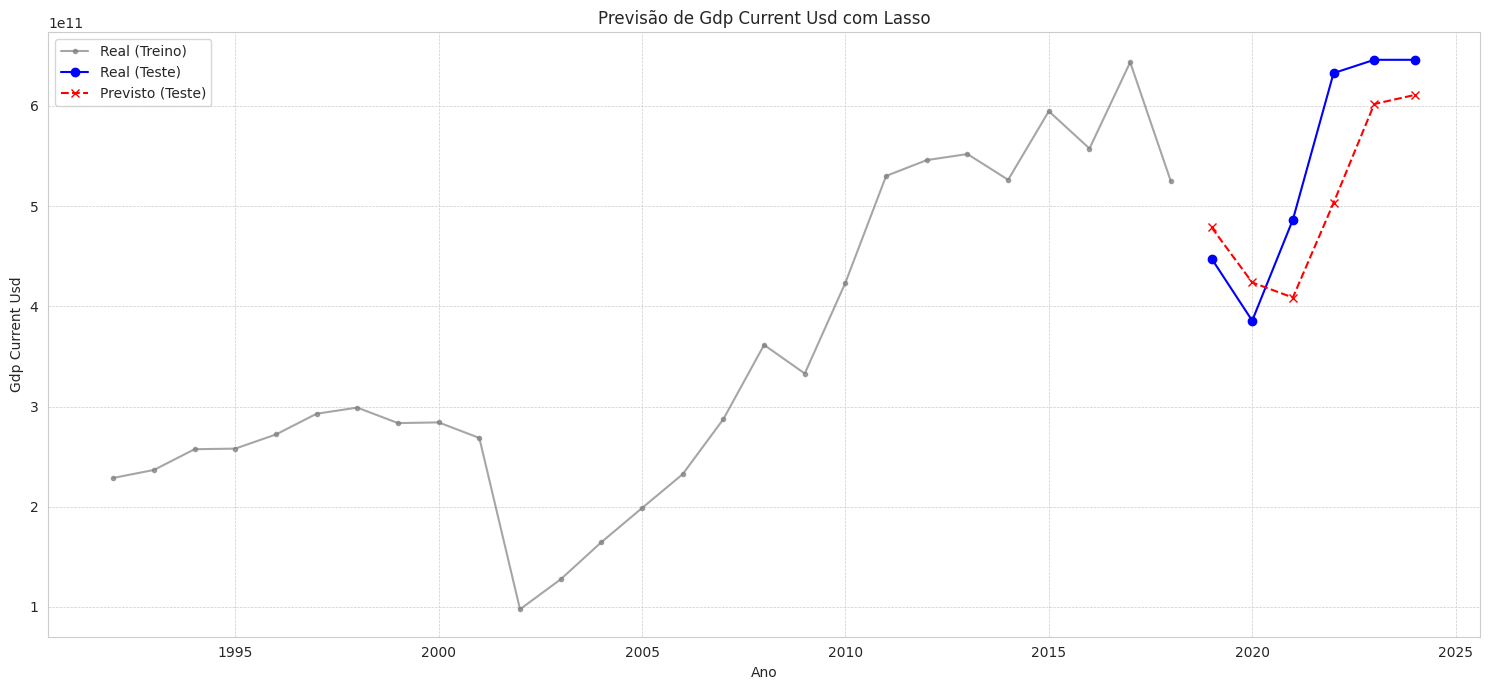

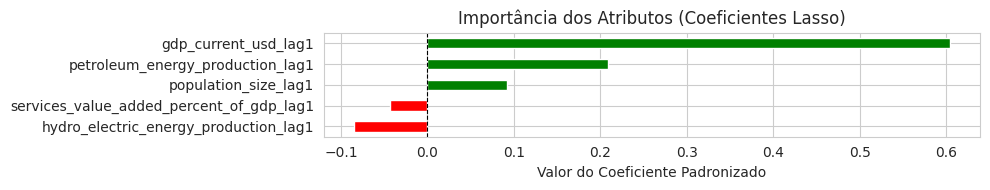

In [28]:
FILE_PATH = 'data_argentina.csv'
TARGET_VARIABLE = 'gdp_current_usd' # <--- ESCOLHA A COLUNA QUE VOCÊ QUER PREVER!
TRAIN_LIMIT_YEAR = 2018
LASSO_PARAMS = {'cv': 5, 'max_iter': 100000, 'n_jobs': -1, 'tol': 0.001, 'n_alphas': 10000}

print(f"Arquivo de Dados: {FILE_PATH}")
print(f"Variável Alvo:    {TARGET_VARIABLE}")
print(f"Ano Limite Treino:{TRAIN_LIMIT_YEAR}")

data = mml.load_and_prepare_data(FILE_PATH)
X, y = mml.engineer_features(data, TARGET_VARIABLE)

# 3. Divisão e Normalização (só continua se X, y foram criados)

split_result = mml.split_and_scale_data(X, y, TRAIN_LIMIT_YEAR)

# 4. Treinamento (só continua se a divisão funcionou)
(X_train_s, X_test_s, y_train_s, y_test_s,
 y_train, y_test, x_scaler, y_scaler) = mml.split_and_scale_data(X, y, TRAIN_LIMIT_YEAR)
model = mml.train_lasso_model(X_train_s, y_train_s, **LASSO_PARAMS)

# 5. Avaliação
y_pred, metrics = mml.evaluate_model(model, X_test_s, y_test, y_test_s, y_scaler)# 6. Visualização e Coeficientes
mml.display_coefficients(model, X.columns)
mml.plot_predictions(y_train, y_test, y_pred, TARGET_VARIABLE)
mml.plot_coefficients(model, X.columns)

In [30]:
mml.explain_coefficients(model, X.columns, TARGET_VARIABLE, x_scaler, y_scaler)

AVISO: O modelo mostra associação, não causalidade. A interpretação descreve padrões nos dados.

Para converter o impacto para a escala original, utilize a seguinte referência:
  -> 1 desvio padrão (DP) de 'gdp_current_usd' equivale a 152,519,256,427.99 unidades.
------------------------------------------------------------
Associações encontradas pelo modelo (na escala padronizada):

🔹 Atributo: gdp_current_usd_lag1
   - Uma variação de 1 desvio padrão neste atributo está associada a uma mudança média de
     +0.6042 desvios padrão (DPs) na variável 'gdp_current_usd'.

🔹 Atributo: petroleum_energy_production_lag1
   - Uma variação de 1 desvio padrão neste atributo está associada a uma mudança média de
     +0.2087 desvios padrão (DPs) na variável 'gdp_current_usd'.

🔹 Atributo: population_size_lag1
   - Uma variação de 1 desvio padrão neste atributo está associada a uma mudança média de
     +0.0915 desvios padrão (DPs) na variável 'gdp_current_usd'.

🔹 Atributo: hydro_electric_energy_